# Import

In [ ]:
# 기본
import pandas as pd
import numpy as np

# Warnings   
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

import re
import urllib.request

# 시각화
%matplotlib inline
import matplotlib.pyplot as plt

# text 처리
import re
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import gensim      # 주피터에서는 pip 사용
from gensim.utils import simple_preprocess

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# 훈련 및 모델 생성
import sklearn
import keras
from sklearn.model_selection import train_test_split

# 1D CNN
from tensorflow.keras.layers import Conv1D, Dropout, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# GRU
from tensorflow.keras.layers import GRU

# confusion matrix
from sklearn.metrics import confusion_matrix     
import seaborn as sns

# Data 전처리

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project/data/appliances_cleaned.csv')

In [ ]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [ ]:
temp = []
data_to_list = df['review_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['Matched pigtail cord and works great. Just what I needed for my electric range. Matched pigtail cord and works great.',
 'complete package I like the fact that the wire ends have mounting tips assembled and that the cord has a strain relief clamp included. Id recommend this to any diy person',
 'Perfect Fit Needed another couple of feet with new dryer, perfect fit. Gives you more options then the shorter cords normally sold.',
 'Everything works Good quality at a reasonable price',
 '50 amp cable Planning on hooking this to my RV']

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['matched', 'pigtail', 'cord', 'and', 'works', 'great', 'just', 'what', 'needed', 'for', 'my', 'electric', 'range', 'matched', 'pigtail', 'cord', 'and', 'works', 'great'], ['complete', 'package', 'like', 'the', 'fact', 'that', 'the', 'wire', 'ends', 'have', 'mounting', 'tips', 'assembled', 'and', 'that', 'the', 'cord', 'has', 'strain', 'relief', 'clamp', 'included', 'id', 'recommend', 'this', 'to', 'any', 'diy', 'person'], ['perfect', 'fit', 'needed', 'another', 'couple', 'of', 'feet', 'with', 'new', 'dryer', 'perfect', 'fit', 'gives', 'you', 'more', 'options', 'then', 'the', 'shorter', 'cords', 'normally', 'sold'], ['everything', 'works', 'good', 'quality', 'at', 'reasonable', 'price'], ['amp', 'cable', 'planning', 'on', 'hooking', 'this', 'to', 'my', 'rv'], ['good', 'range', 'cord', 'standard', 'nema', 'fits', 'with', 'nema', 'this', 'product', 'is', 'pretty', 'simple', 'one', 'do', 'like', 'prettymuch', 'any', 'product', 'made', 'by', 'southwire', 'they', 'make', 'good', 'stuff', '

In [ ]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [ ]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['matched pigtail cord and works great just what needed for my electric range matched pigtail cord and works great', 'complete package like the fact that the wire ends have mounting tips assembled and that the cord has strain relief clamp included id recommend this to any diy person', 'perfect fit needed another couple of feet with new dryer perfect fit gives you more options then the shorter cords normally sold', 'everything works good quality at reasonable price', 'amp cable planning on hooking this to my rv']


In [ ]:
# clean_text 컬럼 생성
df['clean_text'] = data

In [ ]:
# good/bad 개수 확인
df['rating_class'].value_counts()

good    488444
bad      63898
Name: rating_class, dtype: int64

In [ ]:
# good/bad 비율 맞추기 위해 bad 개수에 맞춰서 good 자르기
df = df.sort_values(by='rating_class')
df = df[:130_000]
df['rating_class'].value_counts()

good    66102
bad     63898
Name: rating_class, dtype: int64

In [ ]:
# 필요한 rating_class와 clean_text로만 이루어진 새로운 df 생성
df2 = df[['clean_text', 'rating_class']]

# rating_class를 숫자화 good: 1, bad: 0
df2['rating_class'] = df2['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)

# clean_text에 null값이 있을 수도 있으니 다 드랍하자.
df2 = df2.dropna(subset=['clean_text'])

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130000 entries, 276170 to 315637
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   clean_text    130000 non-null  object
 1   rating_class  130000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ MB


In [ ]:
# bad / good 순서로 되어 있으므로 랜덤으로 섞자.
df2 = sklearn.utils.shuffle(df2)
df2.tail()

,clean_text,rating_class
305519,dont buy this did not fit even though it state...,0
538317,have not been able to install it yet but have ...,1
310274,five stars good product gets rid of chlorine t...,1
359337,good product at good price good product at goo...,1
279845,do not buy this product was told that do not b...,0


In [ ]:
# 토큰화
X = df2['clean_text']
y = df2['rating_class']
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(X)

In [ ]:
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
len(word_index)

33433

In [ ]:
tokenizer = Tokenizer(len(word_index))
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

In [ ]:
# 패딩. 모든 샘플의 길이를 200으로 맞추자.
X = pad_sequences(X, maxlen=200)

# 훈련

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
X_train.shape, X_test.shape

((97500, 200), (32500, 200))

In [ ]:
y_train.shape, y_test.shape

((97500,), (32500,))

# 1D CNN

In [ ]:
model = Sequential()
model.add(Embedding(len(word_index), 256))
model.add(Dropout(0.3))
model.add(Conv1D(256, 3, padding='valid', activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], validation_split=0.2)

Epoch 1/100
2438/2438 [==============================] - 257s 92ms/step - loss: 0.2448 - acc: 0.8934 - val_loss: 0.1398 - val_acc: 0.9477

Epoch 00001: val_acc improved from -inf to 0.94774, saving model to best_model.h5
Epoch 2/100
2438/2438 [==============================] - 224s 92ms/step - loss: 0.1163 - acc: 0.9588 - val_loss: 0.1333 - val_acc: 0.9489

Epoch 00002: val_acc improved from 0.94774 to 0.94887, saving model to best_model.h5
Epoch 3/100
2438/2438 [==============================] - 221s 91ms/step - loss: 0.0798 - acc: 0.9724 - val_loss: 0.1522 - val_acc: 0.9489

Epoch 00003: val_acc improved from 0.94887 to 0.94892, saving model to best_model.h5
Epoch 4/100
2438/2438 [==============================] - 214s 88ms/step - loss: 0.0466 - acc: 0.9838 - val_loss: 0.1785 - val_acc: 0.9479

Epoch 00004: val_acc did not improve from 0.94892
Epoch 5/100
2438/2438 [==============================] - 214s 88ms/step - loss: 0.0312 - acc: 0.9890 - val_loss: 0.2310 - val_acc: 0.9383

Epo

In [ ]:
hist = pd.DataFrame(history.history)

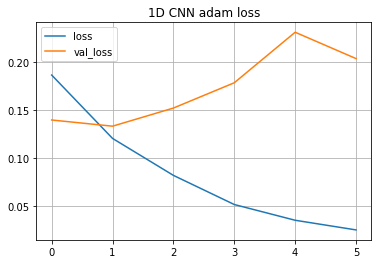

In [ ]:
hist[['loss', 'val_loss']].plot()
plt.title('1D CNN adam loss')
plt.grid()
plt.show()

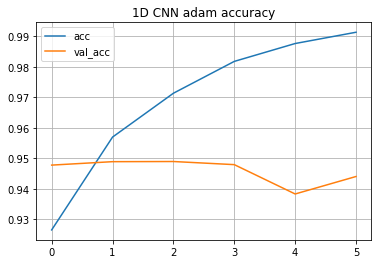

In [ ]:
hist[['acc', 'val_acc']].plot()
plt.title('1D CNN adam accuracy')
plt.grid()
plt.show()

In [ ]:
best_model = keras.models.load_model('best_model.h5')
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=1)
pred = best_model.predict(X_test)
print('model accuracy:', test_acc)

1016/1016 [==============================] - 5s 5ms/step - loss: 0.1556 - acc: 0.9469
model accuracy: 0.9468923211097717


In [ ]:
a = y_test.to_numpy(int)
b = np.around(pred, 0).astype(int).reshape(-1,)

# confusion matrix 만들기
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])

# normalize
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

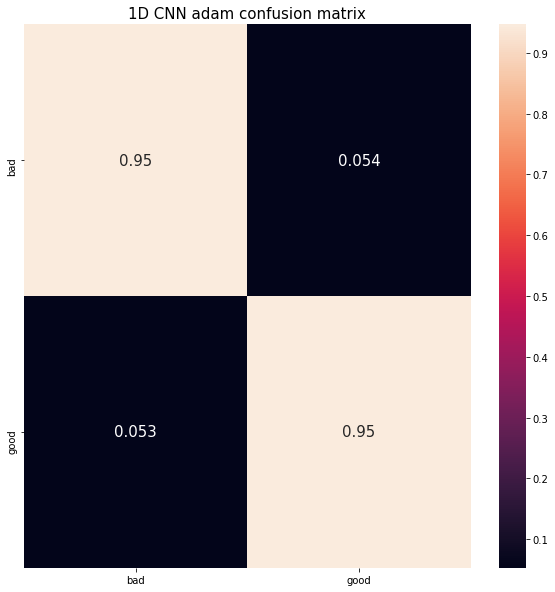

In [ ]:
# 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('1D CNN adam confusion matrix', fontsize=15)
plt.show()

# GRU

In [ ]:
model = Sequential()
model.add(Embedding(len(word_index), 100))
model.add(GRU(128, dropout=0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=4)
mc = ModelCheckpoint('best_model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/100
1300/1300 [==============================] - 124s 94ms/step - loss: 0.2772 - acc: 0.8760 - val_loss: 0.1388 - val_acc: 0.9493

Epoch 00001: val_acc improved from -inf to 0.94928, saving model to best_model2.h5
Epoch 2/100
1300/1300 [==============================] - 121s 93ms/step - loss: 0.1165 - acc: 0.9583 - val_loss: 0.1377 - val_acc: 0.9480

Epoch 00002: val_acc did not improve from 0.94928
Epoch 3/100
1300/1300 [==============================] - 119s 92ms/step - loss: 0.0945 - acc: 0.9673 - val_loss: 0.1407 - val_acc: 0.9485

Epoch 00003: val_acc did not improve from 0.94928
Epoch 4/100
1300/1300 [==============================] - 120s 93ms/step - loss: 0.0805 - acc: 0.9726 - val_loss: 0.1578 - val_acc: 0.9471

Epoch 00004: val_acc did not improve from 0.94928
Epoch 5/100
1300/1300 [==============================] - 121s 93ms/step - loss: 0.0706 - acc: 0.9760 - val_loss: 0.1593 - val_acc: 0.9464

Epoch 00005: val_acc did not improve from 0.94928
Epoch 6/100
1300/1300 

In [ ]:
hist = pd.DataFrame(history.history)

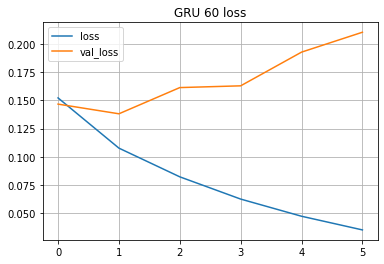

In [ ]:
hist[['loss', 'val_loss']].plot()
plt.title('GRU 60 loss')
plt.grid()
plt.show()

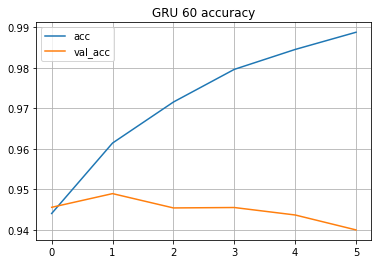

In [ ]:
hist[['acc', 'val_acc']].plot()
plt.title('GRU 60 accuracy')
plt.grid()
plt.show()

In [ ]:
best_model = keras.models.load_model('best_model2.h5')
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=1)
pred = best_model.predict(X_test)
print('model accuracy:', test_acc)

1016/1016 [==============================] - 18s 17ms/step - loss: 0.1333 - acc: 0.9518
model accuracy: 0.9517538547515869


In [ ]:
model = Sequential()
model.add(Embedding(len(word_index), 100))
model.add(GRU(128, dropout=0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=4)
mc = ModelCheckpoint('best_model3.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=512, validation_split=0.2)

Epoch 1/100
153/153 [==============================] - 25s 152ms/step - loss: 0.4397 - acc: 0.7718 - val_loss: 0.1750 - val_acc: 0.9398

Epoch 00001: val_acc improved from -inf to 0.93985, saving model to best_model3.h5
Epoch 2/100
153/153 [==============================] - 22s 147ms/step - loss: 0.1498 - acc: 0.9479 - val_loss: 0.1546 - val_acc: 0.9442

Epoch 00002: val_acc improved from 0.93985 to 0.94415, saving model to best_model3.h5
Epoch 3/100
153/153 [==============================] - 22s 146ms/step - loss: 0.1185 - acc: 0.9589 - val_loss: 0.1479 - val_acc: 0.9466

Epoch 00003: val_acc improved from 0.94415 to 0.94662, saving model to best_model3.h5
Epoch 4/100
153/153 [==============================] - 22s 145ms/step - loss: 0.1019 - acc: 0.9641 - val_loss: 0.1475 - val_acc: 0.9449

Epoch 00004: val_acc did not improve from 0.94662
Epoch 5/100
153/153 [==============================] - 22s 147ms/step - loss: 0.0942 - acc: 0.9689 - val_loss: 0.1501 - val_acc: 0.9467

Epoch 0000

In [ ]:
hist = pd.DataFrame(history.history)

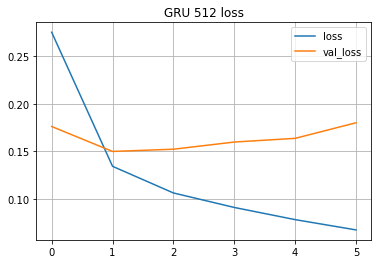

In [ ]:
hist[['loss', 'val_loss']].plot()
plt.title('GRU 512 loss')
plt.grid()
plt.show()

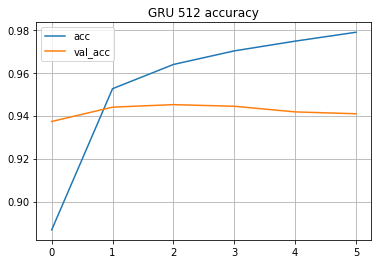

In [ ]:
hist[['acc', 'val_acc']].plot()
plt.title('GRU 512 accuracy')
plt.grid()
plt.show()

In [ ]:
best_model = keras.models.load_model('best_model3.h5')
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=1)
pred = best_model.predict(X_test)
print('model accuracy:', test_acc)

1016/1016 [==============================] - 18s 17ms/step - loss: 0.1445 - acc: 0.9484
model accuracy: 0.9484307765960693
